In [5]:
!pip install seaborn

Looking in indexes: https://artifactory.f.bbg/artifactory/api/pypi/python-proxy-pypi/simple


In [13]:
!ls /srv/models

wmt14.en-fr.joined-dict.transformer


In [1]:
from download_huggingface import download_huggingface_model
download_huggingface_model(
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    local_dir="/srv/models",
    cache_dir="/srv/models/.cache",
    force_download=False,
)

Fetching 28 files:   0%|          | 0/28 [00:00<?, ?it/s]

(…)5ae72e/config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

(…)2efdd961321abdb4782b15ae72e/modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

(…)a2efdd961321abdb4782b15ae72e/config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

(…)21abdb4782b15ae72e/1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

(…)fdd961321abdb4782b15ae72e/.gitattributes:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

(…)0fa2efdd961321abdb4782b15ae72e/README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

(…)782b15ae72e/onnx/model_qint8_avx512.onnx:   0%|          | 0.00/118M [00:00<?, ?B/s]

(…)4782b15ae72e/onnx/model_qint8_arm64.onnx:   0%|          | 0.00/118M [00:00<?, ?B/s]

(…)61321abdb4782b15ae72e/onnx/model_O4.onnx:   0%|          | 0.00/235M [00:00<?, ?B/s]

(…)5ae72e/onnx/model_qint8_avx512_vnni.onnx:   0%|          | 0.00/118M [00:00<?, ?B/s]

(…)4782b15ae72e/onnx/model_quint8_avx2.onnx:   0%|          | 0.00/118M [00:00<?, ?B/s]

(…)61321abdb4782b15ae72e/onnx/model_O3.onnx:   0%|          | 0.00/470M [00:00<?, ?B/s]

(…)4782b15ae72e/openvino/openvino_model.xml:   0%|          | 0.00/399k [00:00<?, ?B/s]

(…)61321abdb4782b15ae72e/onnx/model_O1.onnx:   0%|          | 0.00/470M [00:00<?, ?B/s]

(…)dd961321abdb4782b15ae72e/onnx/model.onnx:   0%|          | 0.00/470M [00:00<?, ?B/s]

(…)61321abdb4782b15ae72e/onnx/model_O2.onnx:   0%|          | 0.00/470M [00:00<?, ?B/s]

(…)nvino/openvino_model_qint8_quantized.bin:   0%|          | 0.00/119M [00:00<?, ?B/s]

(…)nvino/openvino_model_qint8_quantized.xml:   0%|          | 0.00/709k [00:00<?, ?B/s]

(…)961321abdb4782b15ae72e/model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

(…)db4782b15ae72e/sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

(…)abdb4782b15ae72e/sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

(…)abdb4782b15ae72e/special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

(…)4782b15ae72e/openvino/openvino_model.bin:   0%|          | 0.00/470M [00:00<?, ?B/s]

(…)961321abdb4782b15ae72e/pytorch_model.bin:   0%|          | 0.00/471M [00:00<?, ?B/s]

(…)fdd961321abdb4782b15ae72e/tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

(…)21abdb4782b15ae72e/tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

(…)2efdd961321abdb4782b15ae72e/unigram.json:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

(…)a2efdd961321abdb4782b15ae72e/tf_model.h5:   0%|          | 0.00/471M [00:00<?, ?B/s]

In [8]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
import re
import warnings
warnings.filterwarnings('ignore')

class TextClusterer:
    def __init__(self, target_cluster_size: int = 200, embedding_model: str = 'paraphrase-multilingual-MiniLM-L12-v2'):
        """
        Initialiseur du clusterer de texte
        
        Args:
            target_cluster_size: Taille cible pour chaque cluster
            embedding_model: Modèle d'embedding à utiliser
        """
        self.target_cluster_size = target_cluster_size
        self.embedding_model = embedding_model
        self.model = None
        self.embeddings = None
        self.clusters = None
        self.data = None
        
    def load_data(self, file_path: str, text_column: str = None) -> pd.DataFrame:
        """
        Charge les données depuis un fichier Excel
        
        Args:
            file_path: Chemin vers le fichier Excel
            text_column: Nom de la colonne contenant le texte (si None, détection auto)
        
        Returns:
            DataFrame pandas avec les données
        """
        print(f"Chargement des données depuis {file_path}...")
        self.data = pd.read_excel(file_path)
        
        # Détection automatique de la colonne de texte si non spécifiée
        if text_column is None:
            text_columns = []
            for col in self.data.columns:
                if self.data[col].dtype == 'object':
                    # Vérifier si c'est une colonne de texte (longueur moyenne > 10)
                    avg_length = self.data[col].astype(str).str.len().mean()
                    if avg_length > 10:
                        text_columns.append((col, avg_length))
            
            if text_columns:
                text_column = max(text_columns, key=lambda x: x[1])[0]
                print(f"Colonne de texte détectée automatiquement: {text_column}")
            else:
                raise ValueError("Aucune colonne de texte détectée. Spécifiez manuellement text_column.")
        
        self.text_column = text_column
        
        # Nettoyage des données
        self.data = self.data.dropna(subset=[text_column])
        self.data[text_column] = self.data[text_column].astype(str)
        
        print(f"Données chargées: {len(self.data)} lignes")
        return self.data
    
    def preprocess_text(self, text: str) -> str:
        """
        Préprocessing basique du texte
        
        Args:
            text: Texte à nettoyer
            
        Returns:
            Texte nettoyé
        """
        # Suppression des caractères spéciaux et normalisation
        text = re.sub(r'\s+', ' ', text)  # Espaces multiples
        text = text.strip()
        return text
    
    def create_embeddings(self, use_sentence_transformers: bool = True) -> np.ndarray:
        """
        Crée les embeddings pour le texte
        
        Args:
            use_sentence_transformers: Si True, utilise Sentence-BERT, sinon TF-IDF
            
        Returns:
            Matrice d'embeddings
        """
        texts = [self.preprocess_text(text) for text in self.data[self.text_column]]
        
        if use_sentence_transformers:
            print(f"Création des embeddings avec Sentence-BERT ({self.embedding_model})...")
            try:
                self.model = SentenceTransformer(self.embedding_model)
                self.embeddings = self.model.encode(texts, show_progress_bar=True)
            except Exception as e:
                print(f"Erreur avec Sentence-BERT: {e}")
                print("Utilisation de TF-IDF à la place...")
                use_sentence_transformers = False
        
        if not use_sentence_transformers:
            print("Création des embeddings avec TF-IDF...")
            vectorizer = TfidfVectorizer(
                max_features=1000,
                stop_words='english',
                ngram_range=(1, 2),
                min_df=2,
                max_df=0.95
            )
            self.embeddings = vectorizer.fit_transform(texts).toarray()
            self.model = vectorizer
        
        print(f"Embeddings créés: {self.embeddings.shape}")
        return self.embeddings
    
    def estimate_optimal_clusters(self) -> int:
        """
        Estime le nombre optimal de clusters en fonction de la taille cible
        
        Returns:
            Nombre optimal de clusters
        """
        n_samples = len(self.data)
        n_clusters = max(1, n_samples // self.target_cluster_size)
        
        # Ajustement pour éviter des clusters trop petits
        if n_samples % self.target_cluster_size > self.target_cluster_size * 0.5:
            n_clusters += 1
        
        print(f"Nombre de clusters estimé: {n_clusters} (pour ~{self.target_cluster_size} éléments par cluster)")
        return n_clusters
    
    def perform_clustering(self, n_clusters: int = None) -> np.ndarray:
        """
        Effectue le clustering
        
        Args:
            n_clusters: Nombre de clusters (si None, estimation automatique)
            
        Returns:
            Labels des clusters
        """
        if self.embeddings is None:
            raise ValueError("Les embeddings doivent être créés avant le clustering")
        
        if n_clusters is None:
            n_clusters = self.estimate_optimal_clusters()
        
        print(f"Clustering avec {n_clusters} clusters...")
        
        # Utilisation de KMeans avec plusieurs initialisations
        kmeans = KMeans(
            n_clusters=n_clusters,
            n_init=10,
            random_state=42,
            max_iter=300
        )
        
        self.clusters = kmeans.fit_predict(self.embeddings)
        
        # Ajout des labels au DataFrame
        self.data['cluster'] = self.clusters
        
        # Affichage des statistiques
        cluster_sizes = pd.Series(self.clusters).value_counts().sort_index()
        print("\nTailles des clusters:")
        for cluster_id, size in cluster_sizes.items():
            print(f"Cluster {cluster_id}: {size} éléments")
        
        print(f"\nStatistiques:")
        print(f"Taille moyenne: {cluster_sizes.mean():.1f}")
        print(f"Écart-type: {cluster_sizes.std():.1f}")
        print(f"Min: {cluster_sizes.min()}, Max: {cluster_sizes.max()}")
        
        return self.clusters
    
    def get_cluster_representatives(self, n_representatives: int = 5) -> dict:
        """
        Trouve les textes les plus représentatifs de chaque cluster
        
        Args:
            n_representatives: Nombre de représentants par cluster
            
        Returns:
            Dictionnaire avec les représentants par cluster
        """
        if self.clusters is None:
            raise ValueError("Le clustering doit être effectué avant de trouver les représentants")
        
        representatives = {}
        
        for cluster_id in np.unique(self.clusters):
            cluster_mask = self.clusters == cluster_id
            cluster_embeddings = self.embeddings[cluster_mask]
            cluster_texts = self.data[cluster_mask][self.text_column].tolist()
            cluster_indices = self.data[cluster_mask].index.tolist()
            
            # Calcul du centroïde du cluster
            centroid = np.mean(cluster_embeddings, axis=0)
            
            # Calcul des distances au centroïde
            distances = cosine_similarity([centroid], cluster_embeddings)[0]
            
            # Sélection des textes les plus proches du centroïde
            closest_indices = np.argsort(distances)[::-1][:n_representatives]
            
            representatives[cluster_id] = [
                {
                    'index': cluster_indices[i],
                    'text': cluster_texts[i],
                    'similarity': distances[i]
                }
                for i in closest_indices
            ]
        
        return representatives
    
    def save_results(self, output_file: str = 'clustered_verbatims.xlsx') -> None:
        """
        Sauvegarde les résultats dans un fichier Excel
        
        Args:
            output_file: Nom du fichier de sortie
        """
        if self.clusters is None:
            raise ValueError("Le clustering doit être effectué avant la sauvegarde")
        
        print(f"Sauvegarde des résultats dans {output_file}...")
        
        # Création de plusieurs feuilles
        with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
            # Feuille principale avec tous les résultats
            self.data.to_excel(writer, sheet_name='Résultats_clustering', index=False)
            
            # Feuille avec les statistiques par cluster
            cluster_stats = self.data.groupby('cluster').agg({
                self.text_column: ['count', lambda x: x.str.len().mean()]
            }).round(2)
            cluster_stats.columns = ['Nombre_éléments', 'Longueur_moyenne_texte']
            cluster_stats.to_excel(writer, sheet_name='Statistiques_clusters')
            
            # Feuille avec les représentants
            representatives = self.get_cluster_representatives()
            rep_data = []
            for cluster_id, reps in representatives.items():
                for i, rep in enumerate(reps):
                    rep_data.append({
                        'Cluster': cluster_id,
                        'Rang': i + 1,
                        'Index_original': rep['index'],
                        'Similarité': rep['similarity'],
                        'Texte': rep['text']
                    })
            
            rep_df = pd.DataFrame(rep_data)
            rep_df.to_excel(writer, sheet_name='Représentants_clusters', index=False)
        
        print(f"Résultats sauvegardés dans {output_file}")
    
    def plot_cluster_distribution(self) -> None:
        """
        Affiche la distribution des tailles de clusters
        """
        if self.clusters is None:
            raise ValueError("Le clustering doit être effectué avant la visualisation")
        
        cluster_sizes = pd.Series(self.clusters).value_counts().sort_index()
        
        plt.figure(figsize=(12, 6))
        
        # Histogramme des tailles
        plt.subplot(1, 2, 1)
        cluster_sizes.plot(kind='bar')
        plt.title('Taille de chaque cluster')
        plt.xlabel('Cluster ID')
        plt.ylabel('Nombre d\'éléments')
        plt.xticks(rotation=45)
        
        # Distribution des tailles
        plt.subplot(1, 2, 2)
        plt.hist(cluster_sizes.values, bins=20, edgecolor='black')
        plt.axvline(self.target_cluster_size, color='red', linestyle='--', 
                   label=f'Cible: {self.target_cluster_size}')
        plt.title('Distribution des tailles de clusters')
        plt.xlabel('Taille du cluster')
        plt.ylabel('Nombre de clusters')
        plt.legend()
        
        plt.tight_layout()
        plt.show()


def main():
    """
    Fonction principale pour exécuter le clustering
    """
    # Configuration
    FILE_PATH = 'conversation_prod_20250625_20250706_with_categ_llm.xlsx'  # Changez ce chemin selon votre fichier
    TARGET_CLUSTER_SIZE = 200
    OUTPUT_FILE = 'clustered_conversations.xlsx'
    TEXT_COLUMN = 'query_norm'
    EMBEDDING_MODEL = '/srv/models/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
    # Initialisation du clusterer
    clusterer = TextClusterer(target_cluster_size=TARGET_CLUSTER_SIZE, 
                              embedding_model=EMBEDDING_MODEL
                             )
    
    try:
        # 1. Chargement des données
        data = clusterer.load_data(FILE_PATH,TEXT_COLUMN)
        
        # 2. Création des embeddings
        embeddings = clusterer.create_embeddings(use_sentence_transformers=True)
        
        # 3. Clustering
        clusters = clusterer.perform_clustering()
        
        # 4. Sauvegarde des résultats
        clusterer.save_results(OUTPUT_FILE)
        
        # 5. Visualisation (optionnel)
        clusterer.plot_cluster_distribution()
        
        # 6. Affichage de quelques représentants
        print("\n" + "="*50)
        print("REPRÉSENTANTS DES CLUSTERS")
        print("="*50)
        
        representatives = clusterer.get_cluster_representatives(n_representatives=2)
        for cluster_id in sorted(representatives.keys())[:5]:  # Affichage des 5 premiers clusters
            print(f"\nCluster {cluster_id}:")
            for rep in representatives[cluster_id]:
                print(f"  - Similarité {rep['similarity']:.3f}: {rep['text'][:100]}...")
        
        print(f"\n✅ Clustering terminé avec succès!")
        print(f"📁 Résultats sauvegardés dans: {OUTPUT_FILE}")
        
    except Exception as e:
        print(f"❌ Erreur lors du clustering: {e}")
        import traceback
        traceback.print_exc()

Chargement des données depuis conversation_prod_20250625_20250706_with_categ_llm.xlsx...
Données chargées: 45452 lignes
Création des embeddings avec Sentence-BERT (/srv/models/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2)...


Batches:   0%|          | 0/1421 [00:00<?, ?it/s]

Embeddings créés: (45452, 384)
Nombre de clusters estimé: 227 (pour ~200 éléments par cluster)
Clustering avec 227 clusters...

Tailles des clusters:
Cluster 0: 274 éléments
Cluster 1: 3997 éléments
Cluster 2: 5102 éléments
Cluster 3: 490 éléments
Cluster 4: 93 éléments
Cluster 5: 1481 éléments
Cluster 6: 232 éléments
Cluster 7: 1506 éléments
Cluster 8: 62 éléments
Cluster 9: 186 éléments
Cluster 10: 302 éléments
Cluster 11: 125 éléments
Cluster 12: 1606 éléments
Cluster 13: 202 éléments
Cluster 14: 105 éléments
Cluster 15: 107 éléments
Cluster 16: 71 éléments
Cluster 17: 236 éléments
Cluster 18: 104 éléments
Cluster 19: 91 éléments
Cluster 20: 79 éléments
Cluster 21: 76 éléments
Cluster 22: 279 éléments
Cluster 23: 25 éléments
Cluster 24: 89 éléments
Cluster 25: 162 éléments
Cluster 26: 328 éléments
Cluster 27: 97 éléments
Cluster 28: 148 éléments
Cluster 29: 187 éléments
Cluster 30: 252 éléments
Cluster 31: 762 éléments
Cluster 32: 585 éléments
Cluster 33: 132 éléments
Cluster 34: 45

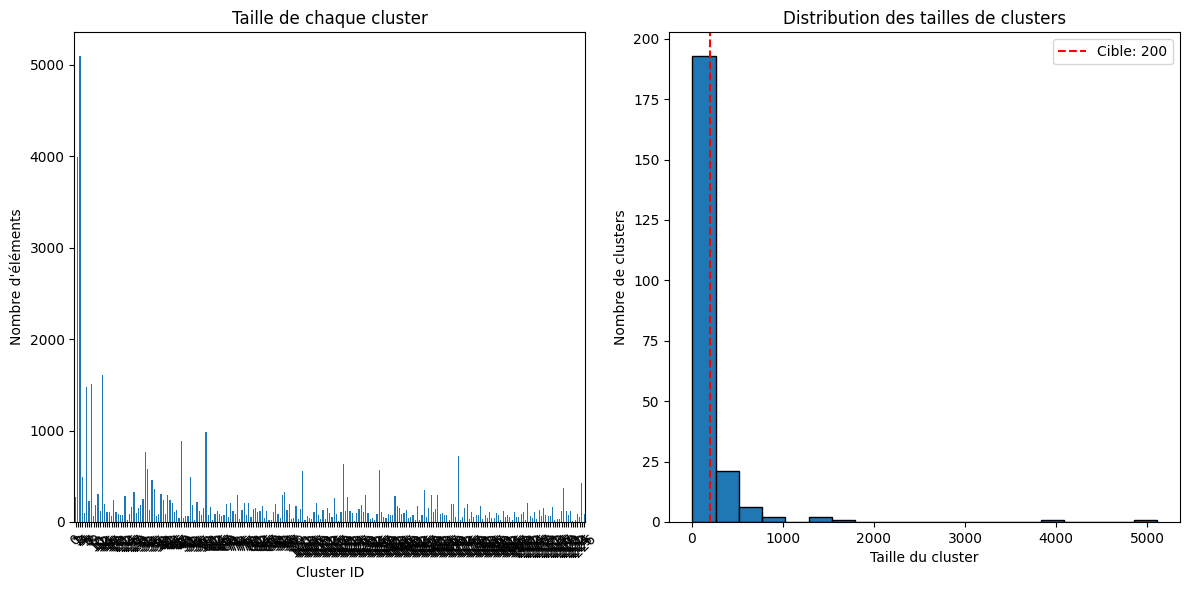


REPRÉSENTANTS DES CLUSTERS

Cluster 0:
  - Similarité 0.993: carte bloquee...
  - Similarité 0.993: carte bloquee...

Cluster 1:
  - Similarité 1.000: effectuer virement instantane...
  - Similarité 1.000: effectuer virement instantane...

Cluster 2:
  - Similarité 1.000: augmenter plafonds carte bancaire...
  - Similarité 1.000: augmenter plafonds carte bancaire...

Cluster 3:
  - Similarité 0.930: augmenter plafon...
  - Similarité 0.930: augmenter plafon...

Cluster 4:
  - Similarité 0.917: compte bloquer...
  - Similarité 0.917: compte bloquer...

✅ Clustering terminé avec succès!
📁 Résultats sauvegardés dans: clustered_conversations.xlsx


In [9]:
main()